## Data Reading (CEI DATA)

In [4]:
import pandas as pd
import os

csvs_dir='../data/submission2/native/nas/papi-turboon'

col_names=['version','app','class','cpu','threads','metric','value']
lst_metrics=['PAPI-TOT-INS', 
             'PAPI-TOT-CYC',             
             'L2-RQSTS-DEMAND-DATA-RD-HIT', 
             'L2-RQSTS-DEMAND-DATA-RD-MISS', 
             'L2-RQSTS-ALL-PF', 
             'L2-RQSTS-PF-HIT', 
             'L2-RQSTS-PF-MISS', 
             'L2-LINES-OUT-USELESS-HWPREF', 
             'L2-LINES-OUT-USELESS-HWPF', 
             'OFFCORE-RESPONSE-0-PF-L2-DATA-RD-ANY-RESPONSE', 
             'OFFCORE-RESPONSE-0-PF-L2-DATA-RD-L3-HIT-SNP-ANY', 
             'OFFCORE-RESPONSE-0-PF-L2-DATA-RD-L3-HIT-SNP-HITM', 
             'OFFCORE-RESPONSE-0-PF-L2-RFO-ANY-RESPONSE', 
             'OFFCORE-RESPONSE-0-PF-L2-RFO-L3-HIT-SNP-ANY', 
             'OFFCORE-RESPONSE-0-PF-L2-RFO-L3-HIT-SNP-HITM', 
             'OFFCORE-REQUESTS-DEMAND-DATA-RD', 
             'OFFCORE-REQUESTS-ALL-DATA-RD', 
             'OFFCORE-REQUESTS-L3-MISS-DEMAND-DATA-RD']

lst_csv_dfs=[]

for csv_filename in os.listdir(csvs_dir):
    if os.path.isdir(csvs_dir+'/'+csv_filename)==True:
        continue
    lst_csv_dfs.append(pd.read_csv(csvs_dir+'/'+csv_filename, names=col_names))

df_all_cei=pd.concat(lst_csv_dfs)
df_all_cei=df_all_cei.sort_values(['version','app','class','threads','cpu'])

#drop some rows with multiple header names
df_all_cei=df_all_cei.loc[df_all_cei['value']!='value'].reset_index(drop=True)
#casting to numeric
#df_all_cei.loc[:,'version']=pd.to_numeric(df_all_cei['version'])
df_all_cei.loc[:,'cpu']=pd.to_numeric(df_all_cei['cpu'])
df_all_cei.loc[:,'threads']=pd.to_numeric(df_all_cei['threads'])
df_all_cei.loc[:,'value']=pd.to_numeric(df_all_cei['value'])
df_all_cei


,version,app,class,cpu,threads,metric,value
0,native-L1,bt,A,0,1,L2-RQSTS-ALL-PF,3411257199
1,native-L1,bt,A,0,1,OFFCORE-RESPONSE-0-PF-L2-DATA-RD-ANY-RESPONSE,0
2,native-L1,bt,A,0,1,L2-RQSTS-DEMAND-DATA-RD-MISS,127731633
3,native-L1,bt,A,0,1,OFFCORE-RESPONSE-0-PF-L2-DATA-RD-L3-HIT-SNP-HITM,0
4,native-L1,bt,A,0,1,OFFCORE-RESPONSE-0-PF-L2-RFO-L3-HIT-SNP-HITM,0
...,...,...,...,...,...,...,...
38875,native-none,ua,A,7,8,PAPI-TOT-INS,29062509735
38876,native-none,ua,A,7,8,L2-LINES-OUT-USELESS-HWPREF,0
38877,native-none,ua,A,7,8,OFFCORE-RESPONSE-0-PF-L2-DATA-RD-L3-HIT-SNP-HITM,0
38878,native-none,ua,A,7,8,L2-RQSTS-ALL-PF,3298632


## Data Preprocessing (CEI DATA)

In [6]:
######## Computing IPC###########################
df_cycles=df_all_cei.loc[df_all_cei['metric']=='PAPI-TOT-CYC']
df_instructions=df_all_cei.loc[df_all_cei['metric']=='PAPI-TOT-INS']

cycles_mean_per_threads=df_cycles.groupby(['version','app','class','cpu','threads']).mean().reset_index()

df_processed_cei=cycles_mean_per_threads[['version','app','class','cpu','threads']].copy()
df_processed_cei['MEAN_CYC']=cycles_mean_per_threads['value']

instr_mean_per_threads=df_instructions.groupby(['version','app','class','cpu','threads']).mean().reset_index()
df_processed_cei['MEAN_INS']=instr_mean_per_threads['value']

df_processed_cei['IPC']=df_processed_cei['MEAN_INS']/df_processed_cei['MEAN_CYC']
######## End Computing IPC ######################

## Standard Metrics (Mean Cycles, Mean Instructions, Instructions per Cycle)

interactive(children=(Dropdown(description='metric', index=2, options=('MEAN_CYC', 'MEAN_INS', 'IPC'), value='…

<function __main__.plot_metrics_graph(metric='IPC', nb_threads='all', _class='A')>

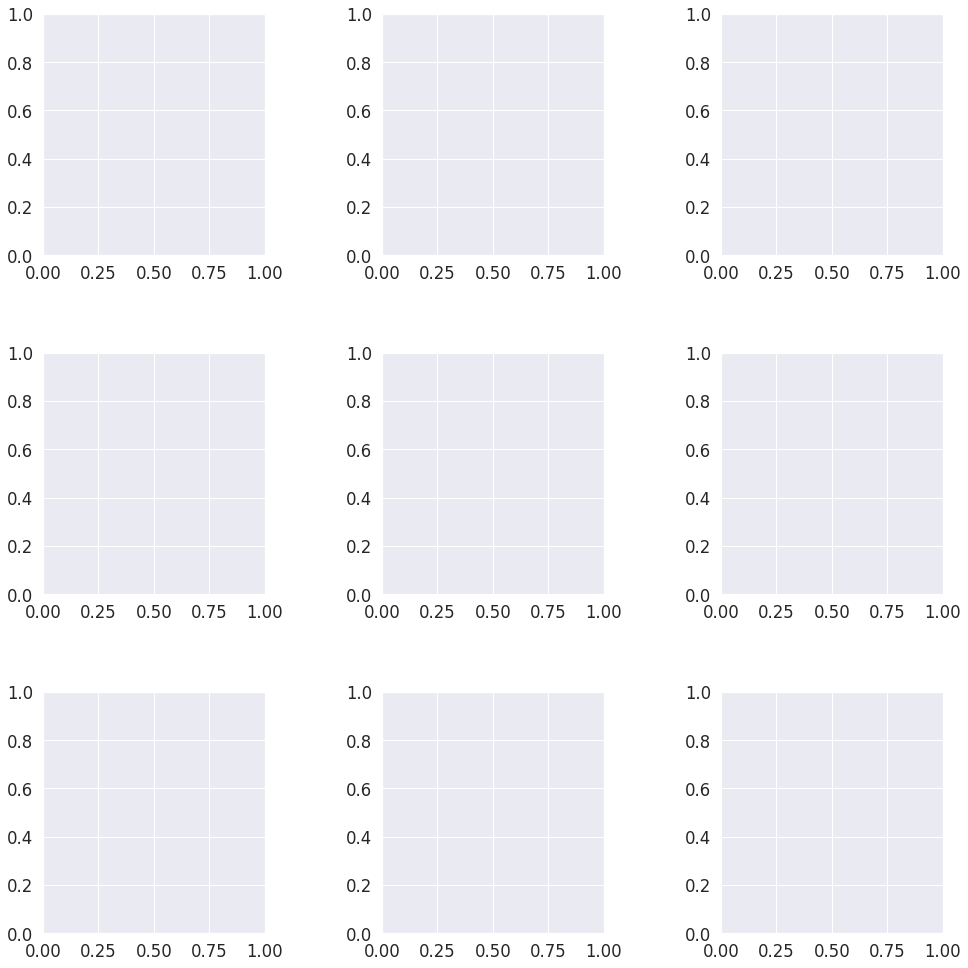

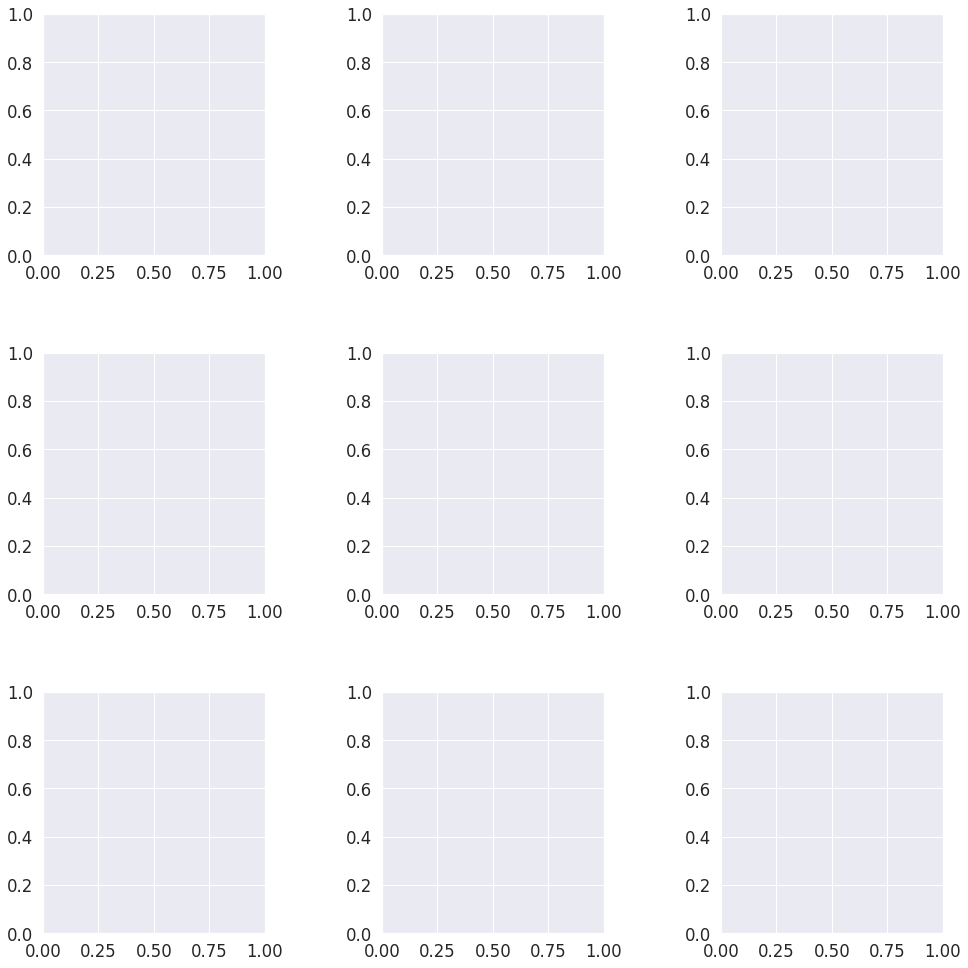

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript,display

#hw_counters=['offcore-response-pf-l2-rfo-l3-hit-any-snoop']
metrics=['MEAN_CYC','MEAN_INS','IPC']
nb_threads=['all','1','2','4','8','12']
classes=['W','A','B']

#df_miss_non0=df_miss.loc[df_miss['cpu']==0]
def plot_metrics_graph(metric='IPC',nb_threads='all',_class='A'):

    apps=['bt','cg','ep','ft','is','lu','mg','sp','ua']
    
    df_metric=df_processed_cei.loc[df_processed_cei['class']==_class]
    if nb_threads!='all':
        df_metric=df_metric.loc[df_metric['threads']==int(nb_threads)]
    #print(df_metric)

    #sns.catplot(x='threads',y='value',hue='version',data=cycles_max_per_threads,kind='bar',col='app',col_wrap=3)
    sns.set(font_scale=1.5)
    fig, axs=plt.subplots(nrows=3,ncols=3,figsize=(15,15))
    plt.tight_layout(pad=3.5)

    for i,app in enumerate(apps):
        row=int(i/3)
        col=int(i%3)
        cycles_app=df_metric.loc[df_metric['app']==app]
        #print(app)        
        if nb_threads=='all':
            sns.barplot(x='threads',y=metric,hue='version',data=cycles_app,ax=axs[row][col],
                        hue_order=['native-L1-L2','native-L2','native-L1','native-none'],palette='cubehelix')
            # legend title
            axs[row][col].legend(framealpha=0.4)
            new_title = 'Execution'
            axs[row][col].legend_.set_title(new_title)            
            # replace labels
            new_labels = ['Real-L1-L2', 'Real-L2', 'Real-L1', 'Real-NoPref']
            for t, l in zip(axs[row][col].legend_.texts, new_labels): t.set_text(l)
            #sns.barplot(x='threads',y=metric,hue='version',data=cycles_app,ax=axs[row][col], hue_order=['native-L1-L2','native-L2','native-L1','native-none','zsim','sniper-none','sniper-l1','sniper-l1-l2'])
        else:
            sns.barplot(x='cpu',y=metric,hue='version',data=cycles_app,ax=axs[row][col],hue_order=['native-L1-L2','native-L2','native-L1','native-none'],palette='cubehelix')
            axs[row][col].legend_.remove()
        
        #sns.barplot(x='threads',y='value',hue='version',data=cycles_app,ax=axs[row][col])
        #sns.catplot(x='threads',y='value',hue='version',data=cycles_app,kind='bar',ax=axs[row][col])
        axs[row][col].set_title(app.upper())
        axs[row][col].set_ylabel('IPC')
        if nb_threads=='all':
            axs[row][col].set_xlabel('Number of Threads')
        else:
            axs[row][col].set_xlabel('Core Index')
        #axs[row][col].set_yscale('log')
        #break

    plt.savefig('../figures/submission2/'+metric+'_'+_class+'_'+nb_threads+'_subm2_cei_turbo.pdf',type='pdf',bbox_inches='tight')
    
dropdown_metrics=widgets.Dropdown(
    options=metrics,
    value='IPC',
    description='metric',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)   
dropdown_classes=widgets.Dropdown(
    options=classes,
    value='A',
    description='class',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
dropdown_nb_threads=widgets.Dropdown(
    options=nb_threads,
    value='all',
    description='nb_threads',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

interact_manual(plot_metrics_graph,                
                metric=dropdown_metrics, 
                nb_threads=dropdown_nb_threads, 
                _class=dropdown_classes)

# Calculating Serpa's IPC

sum -> soma o valor de cada core 

para cada step (cei1.1, cei1.2, cei1.3, cei1.4)
..... para cada prefetch,app,class
..........IPC = sum(PAPI-TOT-INS) / sum(PAPI-TOT-CYC)

assim cria uma "métrica" nova

################# 
agora vai pro teu código já existente e faz a média do IPC (vai ter 1 IPC por step, prefetch, app, class)

In [21]:
# lst_csv_dfs is in order of cei1.1 cei1.2 and so on
import pandas as pd
import os

lst_dfs=[]

for csv_filename in os.listdir(csvs_dir):
    if os.path.isdir(csvs_dir+'/'+csv_filename)==True:
        continue
    _df=pd.read_csv(csvs_dir+'/'+csv_filename, names=col_names)

    # remove repeated entries because of the execution script repeated counters
    # for 'PAPI-TOT-INS' and 'PAPI-TOT-CYC'
    _df=_df.groupby(['version','app','class','cpu','threads','metric']).max().reset_index()


    # sum the metric values for each [prefetch, app, class, threads] 
    df_sum=_df.groupby(['version','app','class','threads','metric']).sum().reset_index()

    # extract the instructions ans cycles
    df_sum_ins=df_sum.loc[df_sum['metric']=='PAPI-TOT-INS'].copy()
    df_sum_cyc=df_sum.loc[df_sum['metric']=='PAPI-TOT-CYC'].copy()


    # create a new dataframe with 'version','app','class','threads'
    # and data about the sum of instructions and cycles and its IPC
    df_new=df_sum[['version','app','class','threads']].groupby(['version','app','class','threads']).max().reset_index().copy()
    df_new.loc[:,'SUM_INS']=df_sum_ins.loc[:,'value'].reset_index(drop=True)
    df_new.loc[:,'SUM_CYC']=df_sum_cyc.loc[:,'value'].reset_index(drop=True)
    df_new['SERPA_IPC']=df_new['SUM_INS']/df_new['SUM_CYC']
    lst_dfs.append(df_new)
    
df_all_serpa=pd.concat(lst_dfs)
df_all_serpa

,version,app,class,threads,SUM_INS,SUM_CYC,SERPA_IPC
0,native-L1,bt,A,1,386907324882,134585253058,2.874812
1,native-L1,bt,A,2,387012094700,136015247213,2.845358
2,native-L1,bt,A,4,399425998182,141149455258,2.829809
3,native-L1,bt,A,8,399892182909,142784975394,2.800660
4,native-L1,bt,A,12,449081676994,161924888797,2.773395
...,...,...,...,...,...,...,...
130,native-none,ua,W,1,30364575666,14611878567,2.078075
131,native-none,ua,W,2,30395657485,15128346726,2.009186
132,native-none,ua,W,4,31015053694,15699046985,1.975601
133,native-none,ua,W,8,31743648717,17161366620,1.849716


## Plotting SERPA_IPC

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript,display

#hw_counters=['offcore-response-pf-l2-rfo-l3-hit-any-snoop']
metrics=['SUM_CYC','SUM_INS','SERPA_IPC']
nb_threads=['all','1','2','4','8','12']
classes=['W','A','B']

#df_miss_non0=df_miss.loc[df_miss['cpu']==0]
def plot_metrics_graph(metric='SERPA_IPC',nb_threads='all',_class='A'):

    apps=['bt','cg','ep','ft','is','lu','mg','sp','ua']

    df_metric=df_all_serpa.loc[df_all_serpa['class']==_class]
    if nb_threads!='all':
        df_metric=df_metric.loc[df_metric['threads']==int(nb_threads)]
    #print(df_metric)

    #sns.catplot(x='threads',y='value',hue='version',data=cycles_max_per_threads,kind='bar',col='app',col_wrap=3)
    sns.set(font_scale=1.5)
    fig, axs=plt.subplots(nrows=3,ncols=3,figsize=(15,15))
    plt.tight_layout(pad=3.5)

    for i,app in enumerate(apps):
        row=int(i/3)
        col=int(i%3)
        cycles_app=df_metric.loc[df_metric['app']==app]
        #print(app)        
        if nb_threads=='all':
            sns.barplot(x='threads',y=metric,hue='version',data=cycles_app,ax=axs[row][col],
                        hue_order=['native-none', 'native-L1'],palette='cubehelix')
            # legend title
            axs[row][col].legend(framealpha=0.4)
            new_title = 'Execution'
            axs[row][col].legend_.set_title(new_title)            
            # replace labels
            new_labels = ['Real-NoPref', 'Real-L1']
            for t, l in zip(axs[row][col].legend_.texts, new_labels): t.set_text(l)
            #sns.barplot(x='threads',y=metric,hue='version',data=cycles_app,ax=axs[row][col], hue_order=['native-L1-L2','native-L2','native-L1','native-none','zsim','sniper-none','sniper-l1','sniper-l1-l2'])
        else:
            sns.barplot(x='cpu',y=metric,hue='version',data=cycles_app,ax=axs[row][col],hue_order=['native-none', 'native-L1'],palette='cubehelix')
            axs[row][col].legend_.remove()
        
        #sns.barplot(x='threads',y='value',hue='version',data=cycles_app,ax=axs[row][col])
        #sns.catplot(x='threads',y='value',hue='version',data=cycles_app,kind='bar',ax=axs[row][col])
        axs[row][col].set_title(app.upper())
        axs[row][col].set_ylabel('SERPA IPC')
        if nb_threads=='all':
            axs[row][col].set_xlabel('Number of Threads')
        else:
            axs[row][col].set_xlabel('Core Index')
        #axs[row][col].set_yscale('log')
        #break

    plt.savefig('../figures/submission2/'+metric+'_'+_class+'_'+nb_threads+'_subm2_cei.pdf',type='pdf',bbox_inches='tight')
    
dropdown_metrics=widgets.Dropdown(
    options=metrics,
    value='SERPA_IPC',
    description='metric',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)   
dropdown_classes=widgets.Dropdown(
    options=classes,
    value='A',
    description='class',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
dropdown_nb_threads=widgets.Dropdown(
    options=nb_threads,
    value='all',
    description='nb_threads',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

interact_manual(plot_metrics_graph, metric=dropdown_metrics, nb_threads=dropdown_nb_threads, _class=dropdown_classes)

interactive(children=(Dropdown(description='metric', index=2, options=('SUM_CYC', 'SUM_INS', 'SERPA_IPC'), val…

<function __main__.plot_metrics_graph(metric='SERPA_IPC', nb_threads='all', _class='A')>

# Plotting one app on W, A, and B

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript,display

#hw_counters=['offcore-response-pf-l2-rfo-l3-hit-any-snoop']
metrics=['MEAN_CYC','MEAN_INS','IPC']
nb_threads=['all','1','2','4','8','12']
classes=['W','A','B']
apps=['bt','cg','ep','ft','is','lu','mg','sp','ua']

#df_miss_non0=df_miss.loc[df_miss['cpu']==0]
def plot_metrics_graph(metric='IPC',nb_threads='all',app='bt'):

    #apps=['bt','cg','ep','ft','is','lu','mg','sp','ua']
    classes=['W','A','B']
    
    df_metric=df_processed_cei.loc[df_processed_cei['app']==app]
    if nb_threads!='all':
        df_metric=df_metric.loc[df_metric['threads']==int(nb_threads)]
    #print(df_metric)

    #sns.catplot(x='threads',y='value',hue='version',data=cycles_max_per_threads,kind='bar',col='app',col_wrap=3)
    sns.set(font_scale=1.5)
    fig, axs=plt.subplots(nrows=1,ncols=3,figsize=(15,5.5))
    plt.tight_layout(pad=3.5)

    for i,_class in enumerate(classes):
        row=int(0)
        col=int(i)
        fig_axs=axs[col]
        cycles_app=df_metric.loc[df_metric['class']==_class]
        #print(cycles_app)        
        if nb_threads=='all':
            sns.barplot(x='threads',y=metric,hue='version',data=cycles_app,ax=fig_axs,
                        hue_order=['native-L1-L2','native-L2','native-L1','native-none'],palette='cubehelix')
            # legend title
            fig_axs.legend(framealpha=0.4)
            legend_title = 'Execution'
            fig_axs.legend_.set_title(legend_title)
            #subgraph_title='Class '+_class
            #fig_axs.set_title(subgraph_title)
            # replace labels
            new_labels = ['Real-L1-L2', 'Real-L2', 'Real-L1', 'Real-NoPref']
            for t, l in zip(fig_axs.legend_.texts, new_labels): t.set_text(l)
            #sns.barplot(x='threads',y=metric,hue='version',data=cycles_app,ax=axs[row][col], hue_order=['native-L1-L2','native-L2','native-L1','native-none','zsim','sniper-none','sniper-l1','sniper-l1-l2'])
        else:
            sns.barplot(x='cpu',y=metric,hue='version',data=cycles_app,ax=fig_axs,hue_order=['native-L1-L2','native-L2','native-L1','native-none'],palette='cubehelix')
            fig_axs.legend_.remove()
        
        #sns.barplot(x='threads',y='value',hue='version',data=cycles_app,ax=axs[row][col])
        #sns.catplot(x='threads',y='value',hue='version',data=cycles_app,kind='bar',ax=axs[row][col])
        fig_axs.set_title(app.upper()+': Class '+_class)
        fig_axs.set_ylabel('IPC')
        if nb_threads=='all':
            fig_axs.set_xlabel('Number of Threads')
        else:
            fig_axs.set_xlabel('Core Index')
        #axs[row][col].set_yscale('log')
        #break

    plt.savefig('../figures/submission2/'+metric+'_'+app+'_'+nb_threads+'_allclass_cei.pdf',type='pdf',bbox_inches='tight')
    
dropdown_metrics=widgets.Dropdown(
    options=metrics,
    value='IPC',
    description='metric',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)   
dropdown_apps=widgets.Dropdown(
    options=apps,
    value='bt',
    description='class',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
dropdown_nb_threads=widgets.Dropdown(
    options=nb_threads,
    value='all',
    description='nb_threads',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

interact_manual(plot_metrics_graph,                
                metric=dropdown_metrics, 
                nb_threads=dropdown_nb_threads, 
                app=dropdown_apps)

interactive(children=(Dropdown(description='metric', index=2, options=('MEAN_CYC', 'MEAN_INS', 'IPC'), value='…

<function __main__.plot_metrics_graph(metric='IPC', nb_threads='all', app='bt')>